# The CRSP sample and market factor

## The US Stock Market

The most commonly used stocks is comprised of U.S.-based common stocks that are listed on the New York Stock Exchange (NYSE), the American Stock Exchange (AMEX), or the National Association of Securities Dealers Automated Quotations (NASDAQ) system.

The primary resource for stocks is the ***Center for Research in Security Prices (CRSP)*** database. CRSP provides data for NYSE-, AMEX-, and NASDAQ-listed securities for the period from December 31, 1925 through the present.

There are several methods to access the CRSP database. 
* The most common method is through Wharton Research Data Services (WRDS), a system implemented by the University of Pennsylvania’s Wharton School of Business that provides a web-based interface for accessing many of the databases frequently used for finance research. 
* Another approach is to directly access the CRSP files stored by WRDS. This method, which is used to obtain the CRSP data used throughout this text, is accomplished by using an SSH client to log into the WRDS system (wrds.wharton.upenn.edu). Once logged into the WRDS system, one can access SAS files that contain the data. 
* A third method is to obtain the data directly from CRSP. 

### The CRSP U.S.-Based Common Stock Sample

For each month $t$, the sample is constructed by taking all U.S.-based common stocks in the CRSP database as of the end of the given month. These securities can be identified using CRSP’s monthly stock names (msenames) file. The set of all securities that are available as of the end of a month $t$ includes all securities in the msenames file that have a start date (***NAMEDT*** field) less than or equal to the last day of the given month and an end date (***NAMEENDT*** field) that is greater than or equal to the last day of month $t$.

U.S.-based common stocks are identified as the subset of these securities that have a share code (***SHRCD*** field in the msenames file) value of either 10 or 11.

### Composition of the CRSP Sample

The month $t$ market capitalization of stock $i$ is calculated as the number of shares outstanding times the price of the stock as of the end of the last trading day of month $t$. The number of shares outstanding, in thousands, is given by the ***SHROUT*** field in CRSP’s monthly stock (msf) file. The month-end price of the stock is taken from the ***ALTPRC*** field from the same file.

We therefore formally define our market capitalization variable, which we denote ***MktCap***, as the absolute value of the product of the ***SHROUT*** and ***ALTPRC*** fields, divided by 1000. We divide by 1000 so that ***MktCap*** measures market capitalization in millions of dollars.

$$
MktCap = \frac{\left|SHROUT\times ALTPRC\right|} {1000}
$$

We take the absolute value because when there is no trading activity in a stock, CRSP reports the price as the negative of the average of the most recent bid and ask prices. There are some cases where either the ***SHROUT*** field or the ***ADJPRC*** field is missing in the CRSP database. In such cases, ***MktCap*** is taken to be missing.

#### Stock Exchange Composition of CRSP Sample

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# PERMNO: the permanent id-number
# SHRCD: share code
# EXCHCD: exchange code, to distinguish different stock markets
# SICCD: SIC, industry code
# RET: return (in percent)
# SHROUT: shares outstanding (in thousands)
# ALTPRC: last traded price in a month
# DLRET: delisting return (in percent)
# DLSTCD: delisting code
CRSP_month = pd.read_csv('crsp_m_stock.csv',usecols=['PERMNO','date','SHRCD','EXCHCD','SICCD','RET','SHROUT','ALTPRC','DLRET','DLSTCD'],low_memory=False)


In [3]:
# U.S.-based common stocks: share code (SHRCD) value of either 10 or 11
CRSP_month = CRSP_month[(CRSP_month['SHRCD']==10)|(CRSP_month['SHRCD']==11)]

In [4]:
# Change date into timestamp
CRSP_month['date']=CRSP_month['date'].astype('str')
CRSP_month['date']=pd.to_datetime(CRSP_month['date'])
CRSP_month['year']=CRSP_month['date'].dt.year
CRSP_month['month']=CRSP_month['date'].dt.month

In [5]:
# Period: from December 1925 through December 2012
CRSP_month = CRSP_month[(CRSP_month['year']>1925)&(CRSP_month['year']<2013)].reset_index(drop=True)

In [6]:
# Calculate MktCap
CRSP_month['MktCap'] = abs(CRSP_month['SHROUT']*CRSP_month['ALTPRC'])/1000

Stocks listed on the NYSE, AMEX, and NASDAQ are indicated with values of 1 or 31, 2 or 32, and 3 or 33, respectively, in the ***EXCHCD*** field.

The CRSP database also contains a small number of stocks traded on alternative exchanges such as the Arca Stock Market (***EXCHCD*** = 4), the Boston Stock Exchange (***EXCHCD*** = 10), the Chicago Stock Exchange (***EXCHCD*** = 13), the Pacific Stock Exchange (***EXCHCD*** = 16), the Philadelphia Stock Exchange (***EXCHCD*** = 17), the Toronto Stock Exchange (***EXCHCD*** = 19), or in the over-the-counter market (***EXCHCD*** = 20).

Finally, an exchange code of −2 indicates that trading in the stock has been halted by the NYSE or AMEX, an exchange code of −1 indicates that the stock has been suspended by the NYSE, AMEX, or NASDAQ, and an exchange code of 0 indicates that the stock is not trading on the NYSE, NASDAQ, or AMEX, with no additional information given.

In [7]:
# The distribution of stocks
CRSP_month.value_counts('EXCHCD')

EXCHCD
 3.0     1626724
 1.0     1252908
 2.0      426919
 0.0       49449
 10.0       1097
-2.0         938
 20.0        801
-1.0         595
 16.0        547
 4.0         438
 17.0        205
 33.0         65
 32.0         45
 31.0         45
 13.0         33
dtype: int64

***The first option***

In [8]:
# Stocks listed on the NYSE, AMEX, and NASDAQ
NYSE = CRSP_month[(CRSP_month['EXCHCD']==1)|(CRSP_month['EXCHCD']==31)]
AMEX = CRSP_month[(CRSP_month['EXCHCD']==2)|(CRSP_month['EXCHCD']==32)]
NASDAQ = CRSP_month[(CRSP_month['EXCHCD']==3)|(CRSP_month['EXCHCD']==33)]
other = CRSP_month[(CRSP_month['EXCHCD']!=1)&(CRSP_month['EXCHCD']!=31)&(CRSP_month['EXCHCD']!=2)&(CRSP_month['EXCHCD']!=32)&(CRSP_month['EXCHCD']!=3)&(CRSP_month['EXCHCD']!=33)]

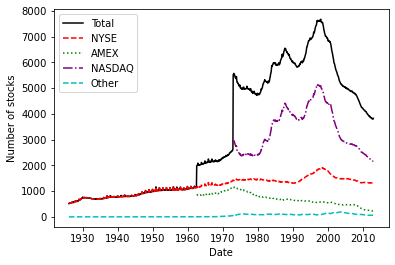

In [9]:
# Figure 7.1 Number of Stocks in CRSP Sample by Exchange
plt.plot(CRSP_month.value_counts('date').sort_index(),c='k',label='Total')
plt.plot(NYSE.value_counts('date').sort_index(),ls='--',c='r',label='NYSE')
plt.plot(AMEX.value_counts('date').sort_index(),ls=':',c='g',label='AMEX')
plt.plot(NASDAQ.value_counts('date').sort_index(),ls='-.',c='purple',label='NASDAQ')
plt.plot(other.value_counts('date').sort_index(),ls='--',c='c',label='Other')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Number of stocks')
plt.show()

In [10]:
# CPI-adjusted total market value
cpi = pd.read_csv('CPIAUCNS.csv').rename(columns={'DATE':'date','CPIAUCNS':'cpi'})
cpi['date']=cpi['date'].astype('str')
cpi['date']=pd.to_datetime(cpi['date'])
cpi['year']=cpi['date'].dt.year
cpi['month']=cpi['date'].dt.month

CRSP_month_cpi = pd.merge(CRSP_month.groupby(['year','month'])['MktCap'].sum(),cpi,on=['year','month'])
CRSP_month_cpi['MktCap_cpi'] = CRSP_month_cpi['MktCap']*CRSP_month_cpi['cpi'].iloc[-1]/CRSP_month_cpi['cpi']

NYSE_cpi = pd.merge(NYSE.groupby(['year','month'])['MktCap'].sum(),cpi,on=['year','month'])
NYSE_cpi['MktCap_cpi'] = NYSE_cpi['MktCap']*NYSE_cpi['cpi'].iloc[-1]/NYSE_cpi['cpi']

AMEX_cpi = pd.merge(AMEX.groupby(['year','month'])['MktCap'].sum(),cpi,on=['year','month'])
AMEX_cpi['MktCap_cpi'] = AMEX_cpi['MktCap']*AMEX_cpi['cpi'].iloc[-1]/AMEX_cpi['cpi']

NASDAQ_cpi = pd.merge(NASDAQ.groupby(['year','month'])['MktCap'].sum(),cpi,on=['year','month'])
NASDAQ_cpi['MktCap_cpi'] = NASDAQ_cpi['MktCap']*NASDAQ_cpi['cpi'].iloc[-1]/NASDAQ_cpi['cpi']

other_cpi = pd.merge(other.groupby(['year','month'])['MktCap'].sum(),cpi,on=['year','month'])
other_cpi['MktCap_cpi'] = other_cpi['MktCap']*other_cpi['cpi'].iloc[-1]/other_cpi['cpi']

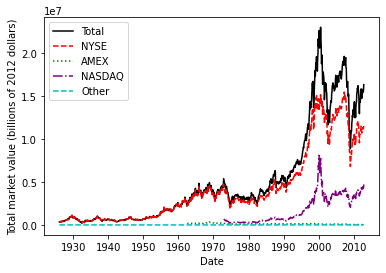

In [11]:
# Figure 7.2 Value of Stocks in CRSP Sample by Exchange
plt.plot(CRSP_month_cpi['date'],CRSP_month_cpi['MktCap_cpi'],c='k',label='Total')
plt.plot(NYSE_cpi['date'],NYSE_cpi['MktCap_cpi'],c='r',ls='--',label='NYSE')
plt.plot(AMEX_cpi['date'],AMEX_cpi['MktCap_cpi'],c='g',ls=':',label='AMEX')
plt.plot(NASDAQ_cpi['date'],NASDAQ_cpi['MktCap_cpi'],c='purple',ls='-.',label='NASDAQ')
plt.plot(other_cpi['date'],other_cpi['MktCap_cpi'],c='c',ls='--',label='Other')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Total market value (billions of 2012 dollars)')
plt.show()

In [12]:
# function to draw cpi-adjusted market value 
def plot_mkt(data):
    temp = pd.merge(data.groupby(['year','month'])['MktCap'].sum(),cpi,on=['year','month'])
    temp['MktCap_cpi'] = temp['MktCap']*temp['cpi'].iloc[-1]/temp['cpi']
    plt.plot(temp['date'],temp['MktCap_cpi'])

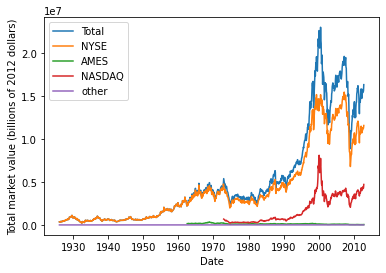

In [13]:
plot_mkt(CRSP_month)
plot_mkt(NYSE)
plot_mkt(AMEX)
plot_mkt(NASDAQ)
plot_mkt(other)
plt.legend(['Total','NYSE','AMES','NASDAQ','other'])
plt.xlabel('Date')
plt.ylabel('Total market value (billions of 2012 dollars)')
plt.show()

***The second option***

In [14]:
# Label each stock market
CRSP_month['stock'] = CRSP_month['EXCHCD'].apply(lambda x:'NYSE'if x==1 or x==31 else ('AMEX' if x==2 or x==32 else ('NASDAQ' if x==3 or x==33 else 'other')))

# Create the dataframe for the numbers counting job
CRSP_month_sum = pd.DataFrame(CRSP_month.value_counts(['date','stock'])).rename(columns={0:'count'}).reset_index(level=[0,1])
CRSP_month_sum

,date,stock,count
0,1996-12-31,NASDAQ,5150
1,1996-11-29,NASDAQ,5124
2,1997-03-31,NASDAQ,5124
3,1997-02-28,NASDAQ,5114
4,1997-04-30,NASDAQ,5112
...,...,...,...
3104,1942-10-31,other,1
3105,1953-10-30,other,1
3106,1942-11-30,other,1
3107,1953-09-30,other,1


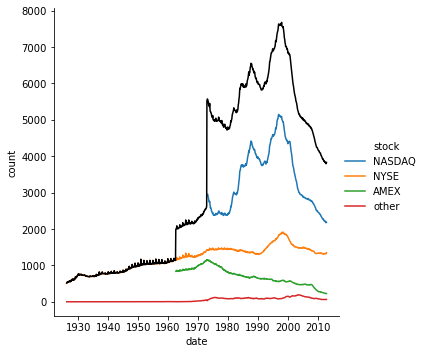

In [15]:
# Figure 7.1 Number of Stocks in CRSP Sample by Exchange
sns.relplot(x='date', y='count',data=CRSP_month_sum, kind='line', hue='stock')
plt.plot(CRSP_month.value_counts('date').sort_index(),c='k',label='Total')
plt.show()

In [16]:
# Create the dataframe for the MktCap
CRSP_month_mktcap = pd.DataFrame(CRSP_month.groupby(['year','month','stock'])['MktCap'].sum()).reset_index(level=[0,1,2])

# Calculate the CPI-adjusted MktCap
CRSP_month_mktcap = pd.merge(CRSP_month_mktcap, cpi, on=['year','month'])
CRSP_month_mktcap['MktCap_cpi'] = CRSP_month_mktcap['MktCap']*CRSP_month_mktcap['cpi'].iloc[-1]/CRSP_month_mktcap['cpi']

CRSP_month_mktcap

,year,month,stock,MktCap,date,cpi,MktCap_cpi
0,1926,1,NYSE,2.774190e+04,1926-01-01,17.900,3.558418e+05
1,1926,1,other,5.031000e+01,1926-01-01,17.900,6.453199e+02
2,1926,2,NYSE,2.831808e+04,1926-02-01,17.900,3.632324e+05
3,1926,2,other,7.188000e+01,1926-02-01,17.900,9.219955e+02
4,1926,3,NYSE,2.608478e+04,1926-03-01,17.800,3.364659e+05
...,...,...,...,...,...,...,...
3104,2012,11,other,1.427095e+01,2012-11-01,230.221,1.423252e+01
3105,2012,12,AMEX,4.501366e+04,2012-12-01,229.601,4.501366e+04
3106,2012,12,NASDAQ,4.700333e+06,2012-12-01,229.601,4.700333e+06
3107,2012,12,NYSE,1.155173e+07,2012-12-01,229.601,1.155173e+07


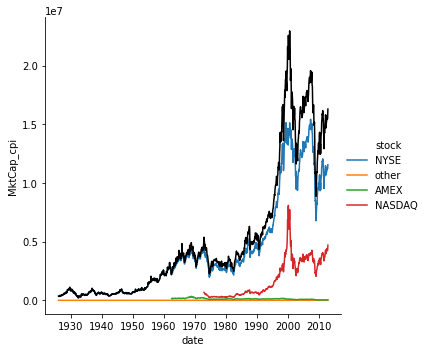

In [17]:
# Figure 7.2 Value of Stocks in CRSP Sample by Exchange
sns.relplot(x='date',y='MktCap_cpi',data=CRSP_month_mktcap, kind='line', hue='stock')
plt.plot(CRSP_month_cpi['date'],CRSP_month_cpi['MktCap_cpi'],c='k',label='Total')
plt.show()

#### Industry Composition of CRSP Sample

We use the [***Standard Industrial Classification (SIC)***](https://www.osha.gov/data/sic-manual) codes to group the stocks into industries. SIC codes are numbers between one and 9999 that indicate the type of business activity conducted by a firm. The SIC code for each of the stocks in the CRSP sample is taken from the ***SICCD*** field in CRSP’s monthly stock names (msenames) file.

**Table 7.1 SIC Industry Code Divisions**

|  SIC Codes   | Industries  |
| :----:   | :----:  |
| 1-999  | Agriculture, forestry, and fishing |
| 1000-1499  | Mining |
|1500-1799|Construction|
|2000-3999|Manufacturing|
|4000-4999|Transportation, communications, electric, gas, and sanitary services|
|5000-5199|Wholesale trade|
|5200-5999|Retail trade|
|6000-6799|Finance, insurance, and real estate|
|7000-8999|Services|
|9000-9999|Public administration|

In [18]:
# Drop the rows if SIC='Z'
CRSP_month =  CRSP_month.drop(CRSP_month[CRSP_month['SICCD']=='Z'].index).reset_index(drop=True)
CRSP_month['SICCD'] = pd.to_numeric(CRSP_month['SICCD'], errors='coerce')
CRSP_month.value_counts('SICCD').sort_index()

SICCD
0       93533
110        51
112       312
115       193
120       947
        ...  
9641       27
9651        9
9910      130
9990      497
9999     5962
Length: 1549, dtype: int64

***The first option***

In [19]:
# Different industries
Missing = CRSP_month[(CRSP_month['SICCD']==0)]
Agriculture = CRSP_month[(CRSP_month['SICCD']>0)&(CRSP_month['SICCD']<1000)]
Mining = CRSP_month[(CRSP_month['SICCD']>999)&(CRSP_month['SICCD']<1500)]
Construction = CRSP_month[(CRSP_month['SICCD']>1499)&(CRSP_month['SICCD']<1800)]
Manufacturing = CRSP_month[(CRSP_month['SICCD']>1999)&(CRSP_month['SICCD']<4000)]
Transportation = CRSP_month[(CRSP_month['SICCD']>3999)&(CRSP_month['SICCD']<5000)]
Wholesale = CRSP_month[(CRSP_month['SICCD']>4999)&(CRSP_month['SICCD']<5200)]
Retail = CRSP_month[(CRSP_month['SICCD']>5199)&(CRSP_month['SICCD']<6000)]
Finance = CRSP_month[(CRSP_month['SICCD']>5999)&(CRSP_month['SICCD']<6800)]
Services = CRSP_month[(CRSP_month['SICCD']>6999)&(CRSP_month['SICCD']<9000)]
Public = CRSP_month[(CRSP_month['SICCD']>8999)&(CRSP_month['SICCD']<10000)]

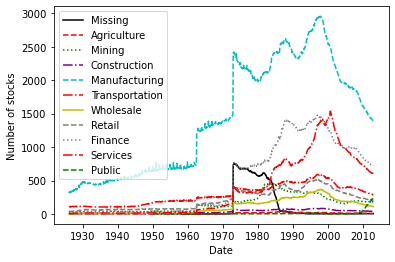

In [20]:
# Figure 7.3 Number of Stocks in CRSP Sample by Industry
plt.plot(Missing.value_counts('date').sort_index(),c='k',label='Missing')
plt.plot(Agriculture.value_counts('date').sort_index(),ls='--',c='r',label='Agriculture')
plt.plot(Mining.value_counts('date').sort_index(),ls=':',c='g',label='Mining')
plt.plot(Construction.value_counts('date').sort_index(),ls='-.',c='purple',label='Construction')
plt.plot(Manufacturing.value_counts('date').sort_index(),ls='--',c='c',label='Manufacturing')
plt.plot(Transportation.value_counts('date').sort_index(),ls='-.',c='r',label='Transportation')
plt.plot(Wholesale.value_counts('date').sort_index(),ls='-',c='y',label='Wholesale')
plt.plot(Retail.value_counts('date').sort_index(),ls='--',c='grey',label='Retail')
plt.plot(Finance.value_counts('date').sort_index(),ls=':',c='grey',label='Finance')
plt.plot(Services.value_counts('date').sort_index(),ls='-.',c='r',label='Services')
plt.plot(Public.value_counts('date').sort_index(),ls='--',c='g',label='Public')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Number of stocks')
plt.show()

In [21]:
Missing_cpi = pd.merge(Missing.groupby(['year','month'])['MktCap'].sum(),cpi,on=['year','month'])
Missing_cpi['MktCap_cpi'] = Missing_cpi['MktCap']*Missing_cpi['cpi'].iloc[-1]/Missing_cpi['cpi']

Agriculture_cpi = pd.merge(Agriculture.groupby(['year','month'])['MktCap'].sum(),cpi,on=['year','month'])
Agriculture_cpi['MktCap_cpi'] = Agriculture_cpi['MktCap']*Agriculture_cpi['cpi'].iloc[-1]/Agriculture_cpi['cpi']

Mining_cpi = pd.merge(Mining.groupby(['year','month'])['MktCap'].sum(),cpi,on=['year','month'])
Mining_cpi['MktCap_cpi'] = Mining_cpi['MktCap']*Mining_cpi['cpi'].iloc[-1]/Mining_cpi['cpi']

Construction_cpi = pd.merge(Construction.groupby(['year','month'])['MktCap'].sum(),cpi,on=['year','month'])
Construction_cpi['MktCap_cpi'] = Construction_cpi['MktCap']*Construction_cpi['cpi'].iloc[-1]/Construction_cpi['cpi']

Manufacturing_cpi = pd.merge(Manufacturing.groupby(['year','month'])['MktCap'].sum(),cpi,on=['year','month'])
Manufacturing_cpi['MktCap_cpi'] = Manufacturing_cpi['MktCap']*Manufacturing_cpi['cpi'].iloc[-1]/Manufacturing_cpi['cpi']

Transportation_cpi = pd.merge(Transportation.groupby(['year','month'])['MktCap'].sum(),cpi,on=['year','month'])
Transportation_cpi['MktCap_cpi'] = Transportation_cpi['MktCap']*Transportation_cpi['cpi'].iloc[-1]/Transportation_cpi['cpi']

Wholesale_cpi = pd.merge(Wholesale.groupby(['year','month'])['MktCap'].sum(),cpi,on=['year','month'])
Wholesale_cpi['MktCap_cpi'] = Wholesale_cpi['MktCap']*Wholesale_cpi['cpi'].iloc[-1]/Wholesale_cpi['cpi']

Retail_cpi = pd.merge(Retail.groupby(['year','month'])['MktCap'].sum(),cpi,on=['year','month'])
Retail_cpi['MktCap_cpi'] = Retail_cpi['MktCap']*Retail_cpi['cpi'].iloc[-1]/Retail_cpi['cpi']

Finance_cpi = pd.merge(Finance.groupby(['year','month'])['MktCap'].sum(),cpi,on=['year','month'])
Finance_cpi['MktCap_cpi'] = Finance_cpi['MktCap']*Finance_cpi['cpi'].iloc[-1]/Finance_cpi['cpi']

Services_cpi = pd.merge(Services.groupby(['year','month'])['MktCap'].sum(),cpi,on=['year','month'])
Services_cpi['MktCap_cpi'] = Services_cpi['MktCap']*Services_cpi['cpi'].iloc[-1]/Services_cpi['cpi']

Public_cpi = pd.merge(Public.groupby(['year','month'])['MktCap'].sum(),cpi,on=['year','month'])
Public_cpi['MktCap_cpi'] = Public_cpi['MktCap']*Public_cpi['cpi'].iloc[-1]/Public_cpi['cpi']

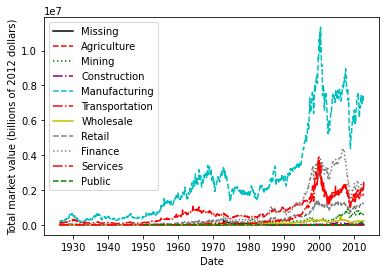

In [22]:
# Figure 7.4 Value of Stocks in CRSP Sample by Industry
plt.plot(Missing_cpi['date'],Missing_cpi['MktCap_cpi'],c='k',label='Missing')
plt.plot(Agriculture_cpi['date'],Agriculture_cpi['MktCap_cpi'],c='r',ls='--',label='Agriculture')
plt.plot(Mining_cpi['date'],Mining_cpi['MktCap_cpi'],c='g',ls=':',label='Mining')
plt.plot(Construction_cpi['date'],Construction_cpi['MktCap_cpi'],c='purple',ls='-.',label='Construction')
plt.plot(Manufacturing_cpi['date'],Manufacturing_cpi['MktCap_cpi'],c='c',ls='--',label='Manufacturing')
plt.plot(Transportation_cpi['date'],Transportation_cpi['MktCap_cpi'],ls='-.',c='r',label='Transportation')
plt.plot(Wholesale_cpi['date'],Wholesale_cpi['MktCap_cpi'],ls='-',c='y',label='Wholesale')
plt.plot(Retail_cpi['date'],Retail_cpi['MktCap_cpi'],ls='--',c='grey',label='Retail')
plt.plot(Finance_cpi['date'],Finance_cpi['MktCap_cpi'],ls=':',c='grey',label='Finance')
plt.plot(Services_cpi['date'],Services_cpi['MktCap_cpi'],ls='-.',c='r',label='Services')
plt.plot(Public_cpi['date'],Public_cpi['MktCap_cpi'],ls='--',c='g',label='Public')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Total market value (billions of 2012 dollars)')
plt.show()

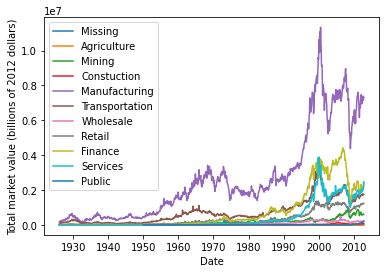

In [23]:
# Use plot function
plot_mkt(Missing)
plot_mkt(Agriculture)
plot_mkt(Mining)
plot_mkt(Construction)
plot_mkt(Manufacturing)
plot_mkt(Transportation)
plot_mkt(Wholesale)
plot_mkt(Retail)
plot_mkt(Finance)
plot_mkt(Services)
plot_mkt(Public)
plt.legend(['Missing','Agriculture','Mining','Constuction','Manufacturing','Transportation','Wholesale','Retail','Finance','Services','Public'])
plt.xlabel('Date')
plt.ylabel('Total market value (billions of 2012 dollars)')
plt.show()

***The second option***

In [24]:
# Label each industry
CRSP_month['industry'] = CRSP_month['SICCD'].apply(lambda x: 'Agriculture' if x>0 and x<1000 
                                                   else ('Mining' if x>999 and x<1500 
                                                         else ('Construction' if x>1499 and x<1800 
                                                               else ('Manufacturing' if x>1999 and x<4000 
                                                                     else ('Transportation' if x>3999 and x<5000 
                                                                           else ('Wholesale' if x>4999 and x<5200 
                                                                                 else ('Retail' if x>5199 and x<6000 
                                                                                       else ('Finance' if x>5999 and x<6800 
                                                                                             else ('Services' if x>6999 and x<9000 
                                                                                                   else ('Public' if x>8999 and x<10000 
                                                                                                         else ('Missing')))))))))))

In [25]:
# Create the dataframe for the count
CRSP_month_sum_ind = pd.DataFrame(CRSP_month.value_counts(['date','industry'])).rename(columns={0:'count'}).reset_index(level=[0,1])
CRSP_month_sum_ind

,date,industry,count
0,1997-12-31,Manufacturing,2955
1,1997-07-31,Manufacturing,2952
2,1997-08-29,Manufacturing,2952
3,1997-11-28,Manufacturing,2950
4,1997-03-31,Manufacturing,2949
...,...,...,...
10418,1963-02-28,Public,1
10419,1963-03-29,Agriculture,1
10420,2003-09-30,Public,1
10421,1963-03-29,Public,1


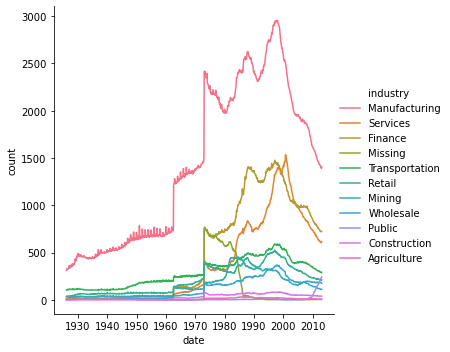

In [26]:
# Figure 7.3 Number of Stocks in CRSP Sample by Industry
sns.relplot(x='date',y='count',data=CRSP_month_sum_ind, kind='line', hue='industry')
plt.show()

In [27]:
# Create the dataframe for the count
CRSP_month_mktcap_ind = pd.DataFrame(CRSP_month.groupby(['year','month','industry'])['MktCap'].sum()).reset_index(level=[0,1,2])

# Calculate the CPI-adjusted MktCap
CRSP_month_mktcap_ind = pd.merge(CRSP_month_mktcap_ind, cpi, on=['year','month'])
CRSP_month_mktcap_ind['MktCap_cpi'] = CRSP_month_mktcap_ind['MktCap']*CRSP_month_mktcap_ind['cpi'].iloc[-1]/CRSP_month_mktcap_ind['cpi']

CRSP_month_mktcap_ind

,year,month,industry,MktCap,date,cpi,MktCap_cpi
0,1926,1,Agriculture,2.701625e+02,1926-01-01,17.900,3.465340e+03
1,1926,1,Construction,1.670000e+01,1926-01-01,17.900,2.142088e+02
2,1926,1,Finance,2.717936e+02,1926-01-01,17.900,3.486262e+03
3,1926,1,Manufacturing,1.573622e+04,1926-01-01,17.900,2.018464e+05
4,1926,1,Mining,1.267863e+03,1926-01-01,17.900,1.626272e+04
...,...,...,...,...,...,...,...
10418,2012,12,Public,2.123613e+05,2012-12-01,229.601,2.123613e+05
10419,2012,12,Retail,1.226136e+06,2012-12-01,229.601,1.226136e+06
10420,2012,12,Services,2.474882e+06,2012-12-01,229.601,2.474882e+06
10421,2012,12,Transportation,1.747964e+06,2012-12-01,229.601,1.747964e+06


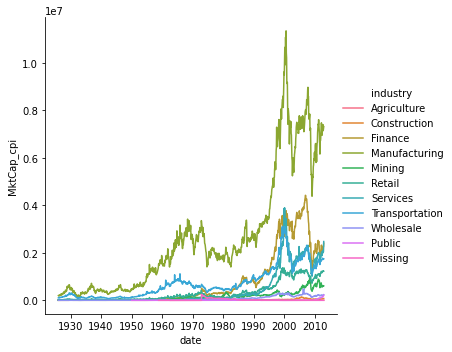

In [28]:
# Figure 7.4 Value of Stocks in CRSP Sample by Industry
sns.relplot(x='date',y='MktCap_cpi',data=CRSP_month_mktcap_ind, kind='line', hue='industry')
plt.show()

## Stock Returns and Excess Returns

Monthly stock returns are found in the ***RET*** field in the monthly stock (msf) file in the CRSP database. The exceptions to this are the months when a stock delists from an exchange. 

The file includes the date of the stock delisting (***DLSTDT*** field), the reason for the delisting (***DLSTCD*** field), and the return realized by an investor who bought the stock at the last traded price in the previous month and held the stock through the delisting (***DLRET*** field). The ***DLRET*** field is known as the delisting return. 

When possible, CRSP determines the price of the stock after the delisting, calculates the return of the stock based on this price (adjusted for any distributions), and reports this value in the ***DLRET*** field. Unfortunately, in many cases, CRSP is not able to determine a post-delisting value of the stock. In such cases, the ***DLRET*** field is missing. To handle these situations, we adjust returns for delisting using an approach suggested by [Shumway (1997)](https://onlinelibrary.wiley.com/doi/abs/10.1111/j.1540-6261.1997.tb03818.x). 

* If a delisting return is available in CRSP, we take the return of the stock to be the delisting return. 
* If a delisting return is unavailable, we rely on the reason for the delisting, as indicated by the ***DLSTCD*** field, to determine the return. 
    * If the DLSTCD is 500, 520, between 551 and 573 inclusive, 574, 580, or 584, we take the stock’s return during the delisting month to be −30%.
    * If DLSTCD has any value other than those mentioned in the previous sentence, we take the return of the stock in the delisting month to be −100%.

In [29]:
# Drop rows if RET is 'B' or 'C'; if DLRET is 'A', 'P', 'S', 'T'
CRSP_month =  CRSP_month.drop(CRSP_month[(CRSP_month['RET']=='B')|(CRSP_month['RET']=='C')].index).reset_index(drop=True)
CRSP_month =  CRSP_month.drop(CRSP_month[(CRSP_month['DLRET']=='A')|(CRSP_month['RET']=='P')|(CRSP_month['RET']=='S')|(CRSP_month['RET']=='T')].index).reset_index(drop=True)

# Multiply by 100
CRSP_month['RET'] = pd.to_numeric(CRSP_month['RET'],errors='coerce')*100
CRSP_month['DLRET'] = pd.to_numeric(CRSP_month['DLRET'],errors='coerce')*100 

In [30]:
# Calculate the adjusted return by delisting
conditions = [
    CRSP_month['DLSTCD']==np.nan, # Not delisting
    (CRSP_month['DLRET']!=np.nan) & (CRSP_month['DLSTCD']!=np.nan), # Delisting with available DLRET
    (np.isin(CRSP_month['DLSTCD'],[500,520,580,584]))|((CRSP_month['DLSTCD']>=551) & (CRSP_month['DLSTCD']<=574))]
choices = [CRSP_month['RET'],CRSP_month['DLRET'], -30]
CRSP_month['RET_adj'] = np.select(conditions, choices, default=-100)

In many cases, it is optimal to examine ***excess stock returns*** instead of simply the stock return. The excess return for a stock is defined as the difference between the stock return and the return on the risk-free security over the same period. The monthly risk-free security return data used throughout this book are taken from [Ken French’s data library](https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html).

In [31]:
# Risk-free return
rf = pd.read_csv('F-F_Factor.csv')

# Change date into timestamp
rf['date'] = pd.to_datetime(rf['date'])
rf['year'] = rf['date'].dt.year
rf['month'] = rf['date'].dt.month
rf = rf.drop(['date'],axis=1)

# Merge together
CRSP_month = pd.merge(CRSP_month, rf, on=['year','month'])

In [32]:
# Calculate the excess stock returns
CRSP_month['RET_rf'] = CRSP_month['RET'] - CRSP_month['RF']
CRSP_month['RET_adj_rf'] = CRSP_month['RET_adj'] - CRSP_month['RF']

CRSP_month[['RET_adj_rf','RET_adj','RET_rf','RET']].describe().T

,count,mean,std,min,25%,50%,75%,max
RET_adj_rf,21056.0,-6.414290,62.240230,-101.3100,-8.469175,0.01085,2.9995,6365.9068
RET_adj,21056.0,-5.995808,62.253788,-100.0000,-8.089500,0.34765,3.4587,6366.6668
RET_rf,3236779.0,0.815458,17.758837,-98.2995,-6.859300,-0.39000,6.6829,2399.6600
RET,3236779.0,1.212575,17.751574,-98.1295,-6.451600,0.00000,7.0649,2400.0000


### CRSP Sample (1963–2012)

The reason for starting the sample in June 1963 is that, as discussed previously, AMEX stocks are included in the CRSP database beginning in July 1962.

## The Market Factor

The market factor, defined as the excess return of the market portfolio, plays a very important role in asset pricing.

According to the Capital Asset Pricing Model (CAPM), cross-sectional variation in expected asset returns is a function of the covariance between the return of the asset and the return on the market portfolio. In practice, most empirical research takes the market portfolio to be comprised of the set (or a subset) of securities traded on the U.S. stock exchanges. The value and returns of such portfolios are easily calculated from widely available security price data.

There are two main proxies for the market portfolio that are commonly used in empirical asset pricing research. 
* The first is the value-weighted portfolio of all U.S.-based common stocks in the CRSP database, we follow common convention by referring to this portfolio and its excess returns as ***MKT***.
* The second is the CRSP value-weighted portfolio, which contains all securities in the CRSP database, not just common stocks, but excluding American Depository Receipts (ADRs). Following CRSP, we denote this portfolio ***VWRETD***.

The main difference between the ***VWRETD*** portfolio and the ***MKT*** portfolio is that the ***VWRETD*** portfolio contains shares of firms that are not based in the United States, closed-end funds, and other securities that are not common stocks.

In [33]:
# MKT portfolio from July 1926 through December 2012
CRSP_month_mkt = pd.DataFrame(CRSP_month.groupby('date')['Mkt-RF'].mean().reset_index())

# Compounded
CRSP_month_mkt['MKT'] = 1+ CRSP_month_mkt['Mkt-RF']/100
CRSP_month_mkt['MKT_com'] = np.cumprod(CRSP_month_mkt['MKT'])

# Log Compounded
CRSP_month_mkt['MKT_log'] = 100*(np.log(1+ CRSP_month_mkt['Mkt-RF']/100))
CRSP_month_mkt['MKT_log_cum'] = np.cumsum(CRSP_month_mkt['MKT_log'])

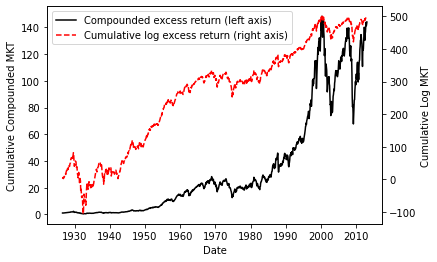

In [34]:
# Figure 7.5 Cumulative Excess Returns of MKT
fig = plt.figure()
ax1 = fig.add_subplot(111)

line1 = ax1.plot(CRSP_month_mkt['date'],CRSP_month_mkt['MKT_com'],c='k',label='Compounded excess return (left axis)')
ax1.set_ylabel('Cumulative Compounded MKT')

ax2 = ax1.twinx()
line2 = ax2.plot(CRSP_month_mkt['date'],CRSP_month_mkt['MKT_log_cum'],c='r',ls='--', label='Cumulative log excess return (right axis)')
ax2.set_ylabel('Cumulative Log MKT')

lines = line1+line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels)
ax1.set_xlabel('Date')
plt.show()

The line representing this value is in some ways misleading, as a quick glance at the solid line would seem to indicate that the returns of the market portfolio were much more volatile toward the end of the sample period than at the beginning. 

This result is simply due to the ***scale*** however, as the same percentage gain or loss is indicated by a larger vertical distance on the chart for the more recent periods, as the cumulative excess returns are larger toward the end of the sample period than at the beginning of the sample period. The cumulative sum of log returns does not suffer from this drawback, but the interpretation of the values on the sum of log excess returns scale is not as simple as those on the compounded excess returns scale.

As can be seen by the chart, the long-run average excess return is very strongly positive, but there are periods for which the portfolio realized substantial and prolonged losses.

 [***Description of Fama/French Factors***](https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/Data_Library/f-f_factors.html)   
>The excess return on the market $R_m-R_f$, value-weight return of all CRSP firms incorporated in the US and listed on the NYSE, AMEX, or NASDAQ that have a CRSP share code of 10 or 11 at the beginning of month $t$, good shares and price data at the beginning of $t$, and good return data for $t$ minus the one-month Treasury bill rate (from Ibbotson Associates). It includes all NYSE, AMEX, and NASDAQ firms.

In [35]:
# Calculate the market factor
# weighted average function
def wavg(group, avg_name, weight_name):
    d=group[avg_name]
    w=group[weight_name]
    try:
        return (d * w).sum() / w.sum()
    except ZeroDivisionError:
        return np.nan

# Include all NYSE, AMEX and NASDAQ firms
CRSP_month1 = CRSP_month[(CRSP_month['stock']=='NYSE')|(CRSP_month['stock']=='AMEX')|(CRSP_month['stock']=='NASDAQ')]

In [36]:
# Market value weighted return
mkt = pd.DataFrame(CRSP_month1.groupby('date').apply(wavg,'RET','MktCap')).reset_index().rename(columns={0:'MKT'})
CRSP_month_mkt1 = pd.DataFrame(CRSP_month1.groupby('date')['RF'].mean().reset_index())
CRSP_month_mkt1 = pd.merge(CRSP_month_mkt1, mkt, on='date')
CRSP_month_mkt1['Mkt'] = CRSP_month_mkt1['MKT']-CRSP_month_mkt1['RF']

# Compounded
CRSP_month_mkt1['MKT_com'] = 1+ CRSP_month_mkt1['Mkt']/100
CRSP_month_mkt1['MKT_com_cum'] = np.cumprod(CRSP_month_mkt1['MKT_com'])

# Log Compounded
CRSP_month_mkt1['MKT_log'] = 100*(np.log(1+ CRSP_month_mkt1['Mkt']/100))
CRSP_month_mkt1['MKT_log_cum'] = np.cumsum(CRSP_month_mkt1['MKT_log'])

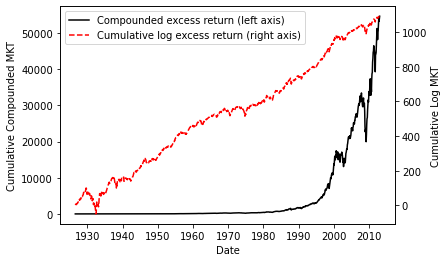

In [37]:
# Figure 7.5 Cumulative Excess Returns of MKT
fig = plt.figure()
ax1 = fig.add_subplot(111)

line1 = ax1.plot(CRSP_month_mkt1['date'],CRSP_month_mkt1['MKT_com_cum'],c='k',label='Compounded excess return (left axis)')
ax1.set_ylabel('Cumulative Compounded MKT')

ax2 = ax1.twinx()
line2 = ax2.plot(CRSP_month_mkt1['date'],CRSP_month_mkt1['MKT_log_cum'],c='r',ls='--', label='Cumulative log excess return (right axis)')
ax2.set_ylabel('Cumulative Log MKT')

lines = line1+line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels)
ax1.set_xlabel('Date')
plt.show()

## The CAPM Risk Model

## Summary